### Cognitive Modeling HW4 Problem 2

In [29]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [30]:
one_high_stan_code = """
data {
  int<lower=1> N_old; // Number of trials
  int<lower=1> N_new; // Number of trials
  array[2] int<lower=0, upper=N_old> freqs_old;
  array[2] int<lower=0, upper=N_new> freqs_new;
}

parameters {
  // Your code here
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[2] theta_old;
  simplex[2] theta_new;
  
  theta_old[1] =  d + (1-d)*g;
  theta_old[2] = (1-d)*(1-g);

  theta_new[1] = g;
  theta_new[2] = (1-g);
}

model {
  // Assuming uniform priors
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs_old | theta_old);
  target += multinomial_lpmf(freqs_new | theta_new);
}

generated quantities{
  array[2] int pred_freqs_old;
  array[2] int pred_freqs_new;

  pred_freqs_old = multinomial_rng(theta_old, N_old);
  pred_freqs_new = multinomial_rng(theta_new, N_new);
}
"""

In [31]:
old_word_freq = [700, 300]
new_word_freq = [350, 650]

data_dict = { 
    'N_old': sum(old_word_freq),
    'N_new': sum(new_word_freq),
    'freqs_old': old_word_freq,
    'freqs_new': new_word_freq
}

one_high_model = stan.build(one_high_stan_code, data=data_dict)


Building...



Building: 17.2s, done.

In [32]:
one_high_fit = one_high_model.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [33]:
# Get the summary of the fit
az.summary(one_high_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.537,0.025,0.491,0.585,0.000,0.000,4957.0,6032.0,1.0
g,0.351,0.015,0.323,0.380,0.000,0.000,5342.0,6271.0,1.0
theta_old[0],0.700,0.015,0.672,0.727,0.000,0.000,7007.0,6641.0,1.0
theta_old[1],0.300,0.015,0.273,0.328,0.000,0.000,7007.0,6641.0,1.0
theta_new[0],0.351,0.015,0.323,0.380,0.000,0.000,5342.0,6271.0,1.0
theta_new[1],0.649,0.015,0.620,0.677,0.000,0.000,5342.0,6271.0,1.0
pred_freqs_old[0],699.764,20.510,661.000,736.000,0.224,0.156,8383.0,8755.0,1.0
pred_freqs_old[1],300.236,20.510,264.000,339.000,0.224,0.156,8383.0,8744.0,1.0
pred_freqs_new[0],350.765,21.270,310.000,389.000,0.258,0.167,6806.0,8147.0,1.0
pred_freqs_new[1],649.235,21.270,609.000,688.000,0.258,0.167,6806.0,8326.0,1.0


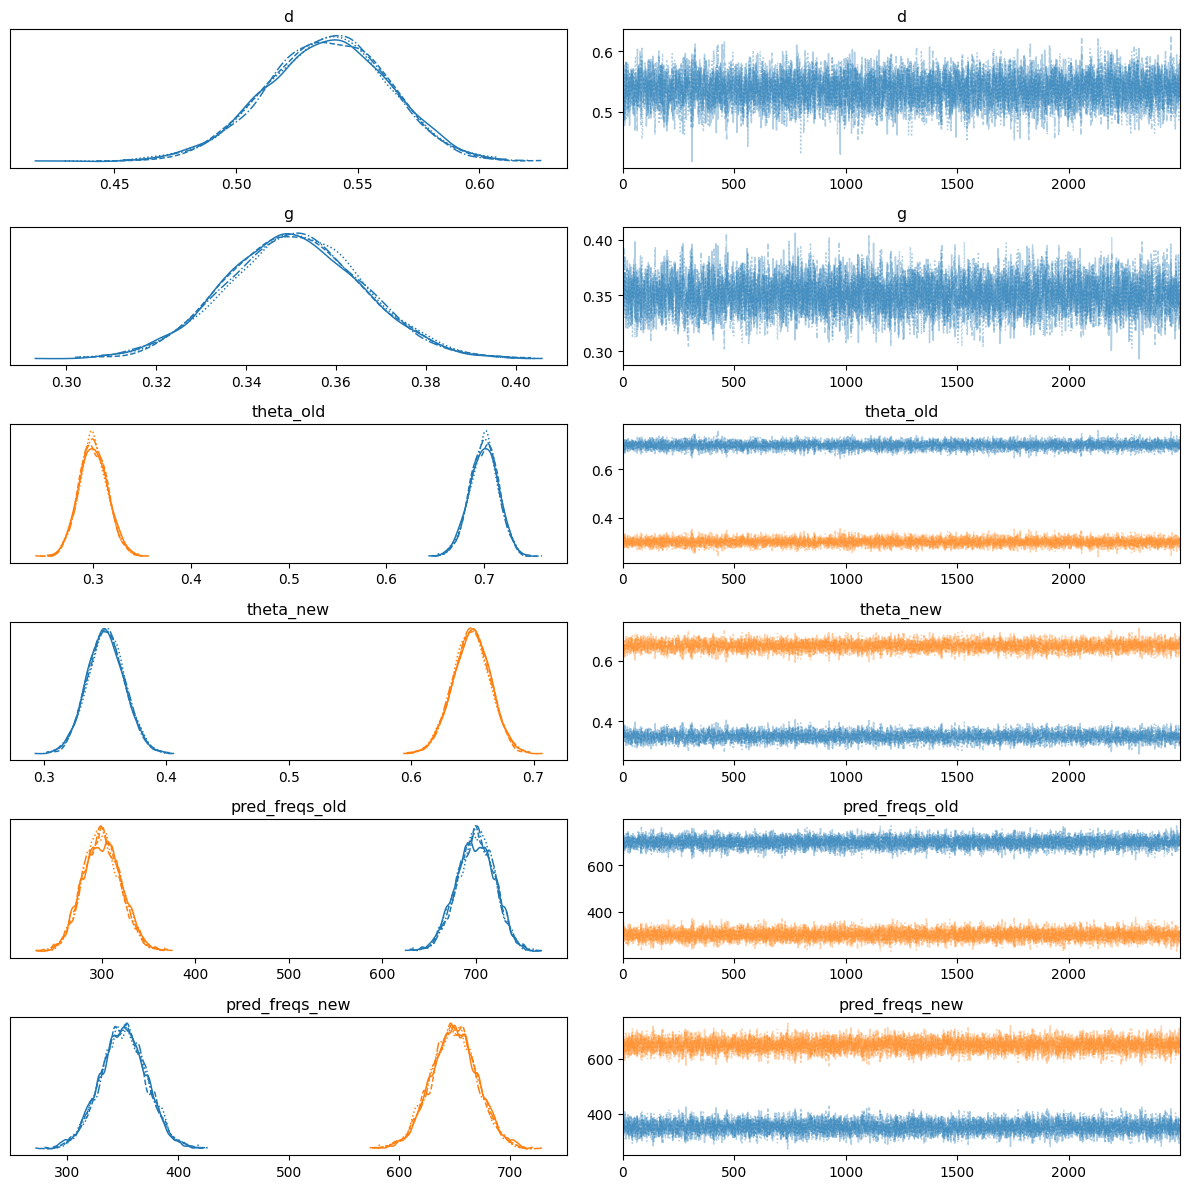

In [34]:
axarr = az.plot_trace(one_high_fit)
plt.tight_layout()

In [35]:
two_high_stan_code = """
data {
  int<lower=1> N_old; // Number of trials
  int<lower=1> N_new; // Number of trials
  array[2] int<lower=0, upper=N_old> freqs_old;
  array[2] int<lower=0, upper=N_new> freqs_new;
}

parameters {
  // Your code here
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[2] theta_old;
  simplex[2] theta_new;
  
  theta_old[1] =  d + (1-d)*g;
  theta_old[2] = (1-d)*(1-g);

  theta_new[1] = (1-d)*g;
  theta_new[2] = d+(1-d)*(1-g);
}

model {
  // Assuming uniform priors
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs_old | theta_old);
  target += multinomial_lpmf(freqs_new | theta_new);
}

generated quantities{
  array[2] int pred_freqs_old;
  array[2] int pred_freqs_new;

  pred_freqs_old = multinomial_rng(theta_old, N_old);
  pred_freqs_new = multinomial_rng(theta_new, N_new);
}
"""

In [36]:
two_high_model = stan.build(two_high_stan_code, data=data_dict)


Building...



Building: 16.4s, done.

In [37]:
two_high_fit = two_high_model.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!


In [38]:
# Get the summary of the fit
az.summary(two_high_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.350,0.021,0.311,0.390,0.000,0.000,9425.0,6611.0,1.0
g,0.538,0.016,0.509,0.570,0.000,0.000,9180.0,6888.0,1.0
theta_old[0],0.700,0.015,0.673,0.727,0.000,0.000,9305.0,6267.0,1.0
theta_old[1],0.300,0.015,0.273,0.327,0.000,0.000,9305.0,6267.0,1.0
theta_new[0],0.350,0.015,0.321,0.378,0.000,0.000,9261.0,6799.0,1.0
theta_new[1],0.650,0.015,0.622,0.679,0.000,0.000,9261.0,6799.0,1.0
pred_freqs_old[0],700.047,20.418,661.000,737.000,0.206,0.171,9848.0,8901.0,1.0
pred_freqs_old[1],299.953,20.418,261.000,337.000,0.206,0.171,9848.0,8766.0,1.0
pred_freqs_new[0],349.712,21.458,306.000,387.000,0.211,0.176,10355.0,8996.0,1.0
pred_freqs_new[1],650.288,21.458,608.000,689.000,0.211,0.176,10355.0,8996.0,1.0


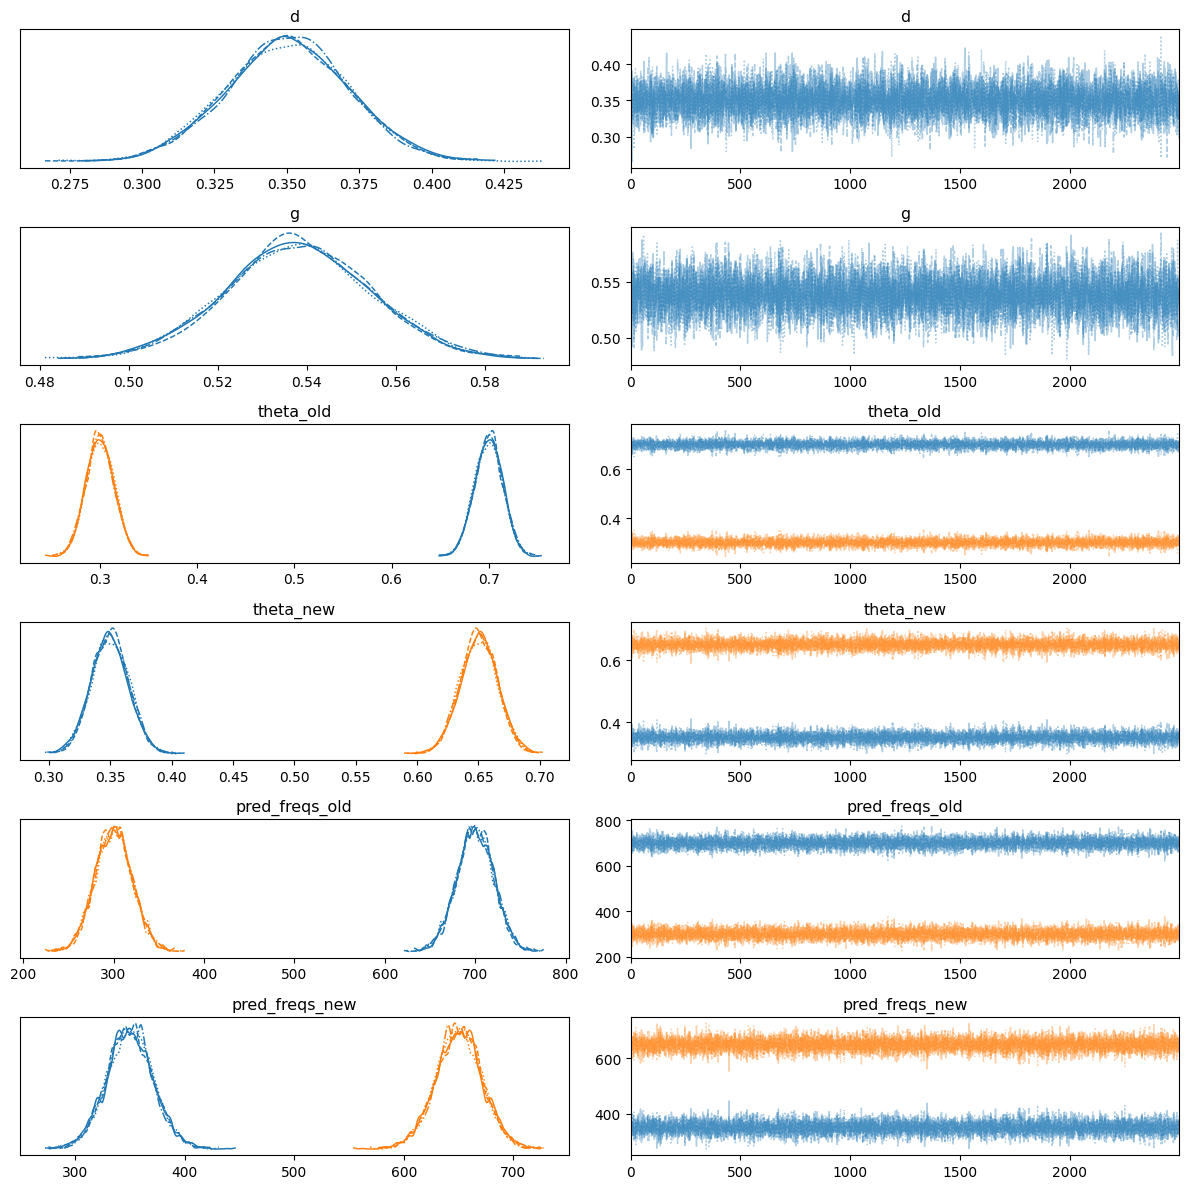

In [39]:
axarr = az.plot_trace(two_high_fit)
plt.tight_layout()